In [276]:
import sys
sys.path += ["../src"]

from opinion_dynamics_models_estimation import simulate_BC
import pandas as pd
import opinion_dynamics_models_estimation as oe


from MSM_calibrator import calibrate_params_ABM
from MSM_simulators import BC_simulator, BC_simulator_positive_observations, BC_simulator_X_evidences, BC_simulator_X_evidences_backfire
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import repeat_function
from matplotlib.patches import Patch

In [295]:
simple_bc_sim = pd.read_csv("../data/compare_simple_bc_230805.csv")
pos_obs_sim = pd.read_csv("../data/compare_pos_bc_230805.csv")
evidences_sim = pd.read_csv("../data/compare_evidences_bc_230805.csv")
backfire_sim = pd.read_csv("../data/compare_backfire_bc_230801.csv")

simple_bc_sim = simple_bc_sim#.query("(T > 16) & (edge_per_t > 1)")
pos_obs_sim = pos_obs_sim#.query("(T > 16) & (edge_per_t > 1)")
evidences_sim = evidences_sim#.query("(T > 16) & (edge_per_t > 1)")
backfire_sim = backfire_sim#.query("(T > 16) & (edge_per_t > 1)")

In [297]:
sns.set_style("whitegrid")
#plt.style.use('seaborn')

palette = sns.color_palette("Set2")

In [298]:
blue, red, green, *_ = sns.color_palette()

sns.set_palette(sns.color_palette())

In [299]:
model_names = ["Fully observed", "Partially observed ", "Noisy observations"]
models = [simple_bc_sim, pos_obs_sim, evidences_sim]
short_model_names = ["BCM-F", "BCM-P", "BCM-N"]

In [300]:
methods_names = ["Likelihood-based", "Simulation-based"]

In [301]:
cond = "(T > 16)&(edge_per_t > 1)"

In [302]:
patches = [Patch(color = sns.color_palette()[i], label = methods_names[i]) for i in range(2)]

In [303]:
len(evidences_sim)

8640

# Epsilon estimated vs real

### Simple 

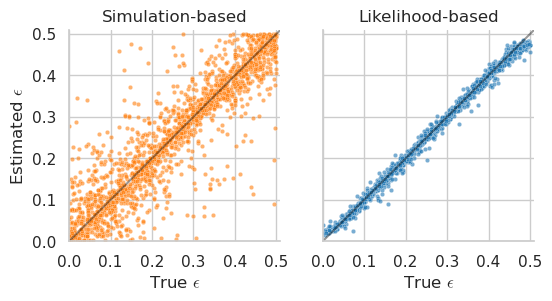

In [304]:
plt.rcParams["mathtext.fontset"] = "cm"

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (6, 3), sharey = True)

max_x = 0.51

axes[0].set_ylabel("Estimated $\epsilon$")

for i, var, title in zip([1,0], ["epsilon_pgabm", "epsilon_msm"], methods_names):
    ax = axes[i]
    ax.margins(x=0, y=0)
    
    ax.plot([0,max_x], [0,max_x], c = "k", alpha = 0.4)
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_x)
    ax.axis("square")
    ax.set_xlabel("True $\epsilon$")
    
    ax.set_title(title)
    
    ax.set_xticks(np.arange(0, 0.51, 0.1))
    ax.set_yticks(np.arange(0, 0.51, 0.1))

    
    sns.scatterplot(data = simple_bc_sim.query(cond),
    #sns.scatterplot(data = simple_bc_sim, 
                    x = "real_epsilon", y = var, s = 10, alpha = 0.6,
                    ax = ax, color = sns.color_palette()[np.abs(i -  1)])


sns.despine()

fig.savefig("../paper/fig/scatterplot_epsilon_simple_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/scatterplot_epsilon_simple_230809.png", format = "png", bbox_inches = "tight")

### Observe Positive

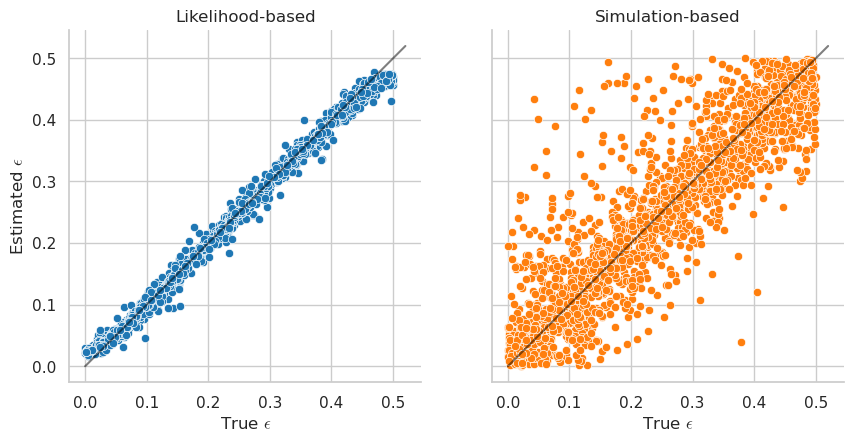

In [305]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5), sharey = True)

max_x = 0.52

axes[0].set_ylabel("Estimated $\epsilon$")

for i, var, title in zip(range(2), ["epsilon_pgabm", "epsilon_msm"], methods_names):
    ax = axes[i]
    
    ax.plot([0,max_x], [0,max_x], c = "k", alpha = 0.5)
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_x)
    ax.axis("square")
    ax.set_xlabel("True $\epsilon$")
    
    ax.set_title(title)

    
    sns.scatterplot(data = pos_obs_sim.query(cond), 
#    sns.scatterplot(data = pos_obs_sim, 
                    x = "real_epsilon", y = var, 
                    ax = ax, color = sns.color_palette()[i])


sns.despine()

#fig.savefig("../paper/fig/scatterplot_epsilon_pos_obs_230803.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/scatterplot_epsilon_pos_obs_230803.png", format = "png", bbox_inches = "tight")

### BC with evidences

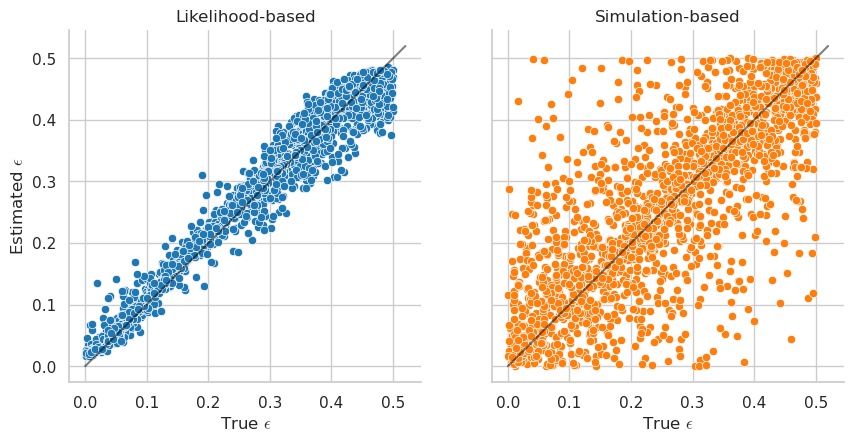

In [306]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5), sharey = True)

max_x = 0.52

axes[0].set_ylabel("Estimated $\epsilon$")

for i, var, title in zip(range(2), ["epsilon_pgabm", "epsilon_msm"], methods_names):
    ax = axes[i]
    
    ax.plot([0,max_x], [0,max_x], c = "k", alpha = 0.5)
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_x)
    ax.axis("square")
    ax.set_xlabel("True $\epsilon$")
    
    ax.set_title(title)

    
    sns.scatterplot(data = evidences_sim.query(cond).query("evidences_per_t == 4"), 
#    sns.scatterplot(data = evidences_sim.query("evidences_per_t == 4"),
                    x = "real_epsilon", y = var, 
                    ax = ax, color = sns.color_palette()[i])


sns.despine()

#fig.savefig("../paper/fig/scatterplot_epsilon_evidences_230803.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/scatterplot_epsilon_evidences_230803.png", format = "png", bbox_inches = "tight")

## Error epsilon

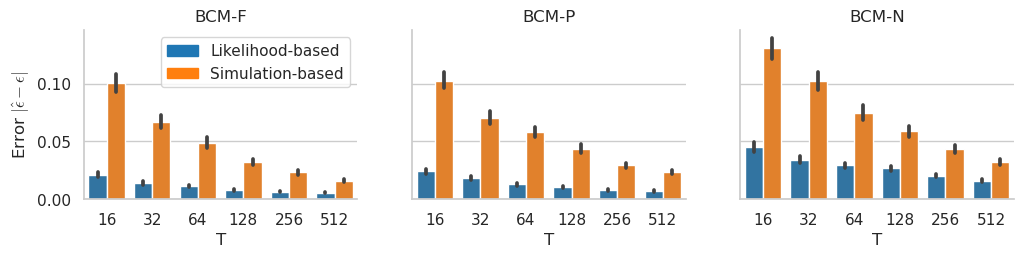

In [307]:
plt.rcParams["mathtext.fontset"] = "cm"
dist_eps_string = r"Error $\vert \hat{\epsilon} - \epsilon \vert$"

sns.set_context("notebook")

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 2.2), sharey = True)

for ax, model, model_name in zip(axes, [simple_bc_sim, pos_obs_sim, evidences_sim.query("evidences_per_t == 4")], 
                                 short_model_names):
    sns.barplot(data = model.set_index(["T", "edge_per_t"])[["abs_error_pgabm", "abs_error_msm"]]\
    #sns.barplot(data = model.set_index(["T", "edge_per_t"]).query(cond)[["abs_error_pgabm", "abs_error_msm"]]\
                .rename(columns = {"abs_error_pgabm": "pgabm", "abs_error_msm": "msm"}).stack().reset_index()\
                .rename(columns = {"level_2": "method", 0: "abs_error"}), 
                x = "T", y = "abs_error", 
                hue = "method", 
                errorbar = ("ci", 95),
                ax = ax
               )
    ax.set_title(model_name)       
    if ax == axes[0]:
        ax.legend(handles = patches, loc = "upper right")
    else:
        ax.legend([],[], frameon = False)
    ax.set_ylabel(dist_eps_string if ax == axes[0] else "")


sns.despine()


fig.savefig("../paper/fig/barplot_shortnames_abs_error_T_methods_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/barplot_shortnames_abs_error_T_methods_230809.png", format = "png", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_T_230807.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_T_230807.png", format = "png", bbox_inches = "tight")

### Edge per t

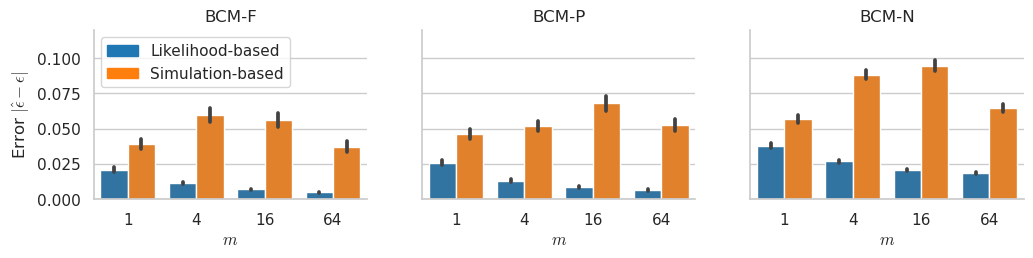

In [308]:
dist_eps_string = r"Error $\vert \hat{\epsilon} - \epsilon \vert$"

sns.set_context("notebook")

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 2.2), sharey = True)

for ax, model, model_name in zip(axes, [simple_bc_sim, pos_obs_sim, evidences_sim], short_model_names):
    #sns.barplot(data = model.query(cond).set_index(["T", "edge_per_t"])[["abs_error_pgabm", "abs_error_msm"]]\
    sns.barplot(data = model.set_index(["T", "edge_per_t"])[["abs_error_pgabm", "abs_error_msm"]]\
                .rename(columns = {"abs_error_pgabm": "pgabm", "abs_error_msm": "msm"}).stack().reset_index()\
                .rename(columns = {"level_2": "method", 0: "abs_error"}), 
                x = "edge_per_t", y = "abs_error", 
                hue = "method", 
                errorbar = ("ci", 95),
                ax = ax
               )
    ax.set_title(model_name)       
    if ax == axes[0]:
        ax.legend(handles = patches, loc = "upper left")
    else:
        ax.legend([],[], frameon = False)
    ax.set_ylabel(dist_eps_string if ax == axes[0] else "")
    ax.set_xlabel("$m$")
    ax.set_ylim(0,0.12)


sns.despine()


fig.savefig("../paper/fig/barplot_shortnames_abs_error_methods_edge_per_t_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/barplot_shortnames_abs_error_methods_edge_per_t_230809.png", format = "png", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_edge_per_t_230807.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_edge_per_t_230807.png", format = "png", bbox_inches = "tight")

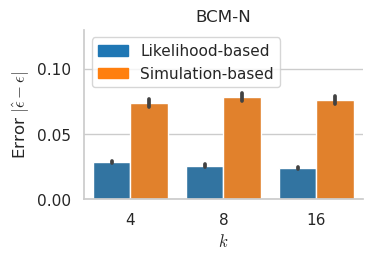

In [309]:
plt.rcParams["mathtext.fontset"] = "cm"
dist_eps_string = r"Error $\vert \hat{\epsilon} - \epsilon \vert$"

sns.set_context("notebook")

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3.6, 2.2), sharey = True)

for model, model_name in zip([evidences_sim], [short_model_names[-1]]):
#    sns.barplot(data = model.query(cond).set_index(["T", "evidences_per_t"])[["abs_error_pgabm", "abs_error_msm"]]\
    sns.barplot(data = model.set_index(["T", "evidences_per_t"])[["abs_error_pgabm", "abs_error_msm"]]\
                .rename(columns = {"abs_error_pgabm": "pgabm", "abs_error_msm": "msm"}).stack().reset_index()\
                .rename(columns = {"level_2": "method", 0: "abs_error"}), 
                x = "evidences_per_t", y = "abs_error", 
                hue = "method", 
                errorbar = ("ci", 95),
                ax = ax
               )
    ax.set_title(model_name)       
    ax.set_xlabel("$k$")

    ax.legend(handles = patches, loc = "upper left")
    
    ax.set_ylabel(dist_eps_string)
    ax.set_ylim(0, 0.13)


sns.despine()


fig.savefig("../paper/fig/barplot_shortnames_abs_error_methods_evidences_per_t_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/barplot_shortnames_abs_error_methods_evidences_per_t_230809.png", format = "png", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_evidences_per_t_230807.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_abs_error_methods_evidences_per_t_230807.png", format = "png", bbox_inches = "tight")

In [310]:
for model, model_name in zip([simple_bc_sim, pos_obs_sim, evidences_sim], model_names):
    print(model_name)
    print("Average error pgabm", round(model.mean()["abs_error_pgabm"], 3))
    print("Average error MSM", round(model.mean()["abs_error_msm"], 3))
    print("Average error ratio", round(model.mean()["abs_error_msm"] / model.mean()["abs_error_pgabm"], 3))
    print("")
    

Fully observed
Average error pgabm 0.011
Average error MSM 0.048
Average error ratio 4.33

Partially observed 
Average error pgabm 0.014
Average error MSM 0.055
Average error ratio 4.027

Noisy observations
Average error pgabm 0.026
Average error MSM 0.076
Average error ratio 2.92



In [311]:
for model, model_name in zip([simple_bc_sim, pos_obs_sim, evidences_sim, pd.concat([simple_bc_sim, pos_obs_sim, evidences_sim])],
                             model_names + ["Aggregate"]):
    print(model_name)
    print("Average error pgabm", round(model.median()["abs_error_pgabm"], 3))
    print("Average error MSM", round(model.median()["abs_error_msm"], 3))
    print("Average error ratio", round(model.assign(ratio_error = lambda x: x["abs_error_msm"] / x["abs_error_pgabm"]).median()["ratio_error"], 3))
    print("")
    

Fully observed
Average error pgabm 0.006
Average error MSM 0.027
Average error ratio 3.963

Partially observed 
Average error pgabm 0.008
Average error MSM 0.036
Average error ratio 4.412

Noisy observations
Average error pgabm 0.018
Average error MSM 0.047
Average error ratio 2.6

Aggregate
Average error pgabm 0.013
Average error MSM 0.04
Average error ratio 3.121



## Time

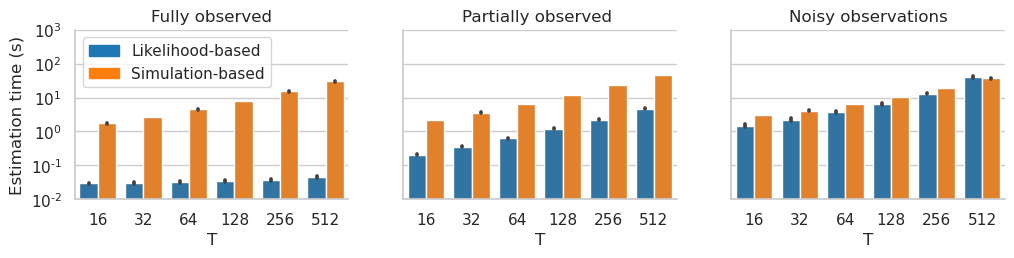

In [312]:
plt.rcParams["mathtext.fontset"] = "cm"

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 2.2), sharey = True)

for ax, model, model_name in zip(axes, [simple_bc_sim, pos_obs_sim, evidences_sim],model_names):
    sns.barplot(data = model.set_index(["T", "edge_per_t"])[["time_pgabm", "time_msm"]]\
                .rename(columns = {"time_pgabm": "pgabm", "time_msm": "msm"}).stack().reset_index()\
                .rename(columns = {"level_2": "method", 0: "time"}), 
                x = "T", y = "time", 
                hue = "method", 
                errorbar = ("ci", 95),
                ax = ax
               )
    ax.set_title(model_name)  
    ax.set_yscale("log")
    if ax == axes[0]:
        ax.legend(handles = patches, loc = "upper left")
    else:
        ax.legend([],[], frameon = False)
    ax.set_ylim(10**-2,10**3)
    ax.set_ylabel("Estimation time (s)" if ax == axes[0] else "")

sns.despine()

fig.savefig("../paper/fig/barplot_time_methods_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/barplot_time_methods_230809.png", format = "png", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_shortnames_time_methods_230807.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_shortnames_time_methods_230807.png", format = "png", bbox_inches = "tight")

In [313]:
for model, model_name in zip([simple_bc_sim, pos_obs_sim, evidences_sim, pd.concat([simple_bc_sim, pos_obs_sim, evidences_sim])], 
                             model_names + ["Aggregate"]):
    print(model_name)
    print("Average time pgabm", round(model.median()["time_pgabm"], 3))
    print("Average time MSM", round(model.median()["time_msm"], 3))
    print("Average time ratio", round(model.assign(ratio_time = lambda x: x["time_msm"] / x["time_pgabm"]).median()["ratio_time"], 3))
    print("")
    

Fully observed
Average time pgabm 0.027
Average time MSM 6.117
Average time ratio 207.011

Partially observed 
Average time pgabm 0.865
Average time MSM 10.401
Average time ratio 11.856

Noisy observations
Average time pgabm 4.434
Average time MSM 8.957
Average time ratio 2.171

Aggregate
Average time pgabm 1.724
Average time MSM 7.531
Average time ratio 3.927



## Distribution R2 X0

In [314]:
evidences_sim[["edge_per_t", "T", "evidences_per_t", "X0_r2", "abs_error_msm", "abs_error_pgabm"]].corr()[["X0_r2", "abs_error_pgabm"]]

,X0_r2,abs_error_pgabm
edge_per_t,-0.057467,-0.196138
T,0.339324,-0.304685
evidences_per_t,0.264074,-0.069211
X0_r2,1.000000,-0.356542
abs_error_msm,-0.173878,0.114081
abs_error_pgabm,-0.356542,1.000000


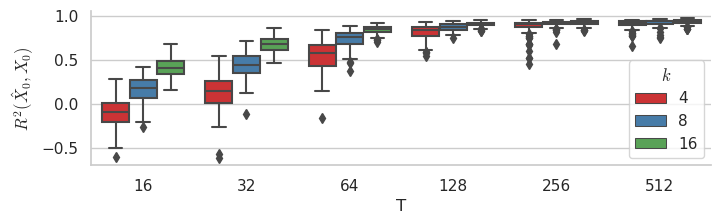

In [315]:
plt.rcParams["mathtext.fontset"] = "cm"

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 2), sharey = True)

   
sns.boxplot(data = evidences_sim.query("edge_per_t == 4"),
            x = "T", y = "X0_r2",
            hue = "evidences_per_t", palette = "Set1")
axes.legend(title = "$k$",loc = "lower right")
axes.set_ylabel("$R^2(\hat{X}_0, X_0)$")
    
    

sns.despine()

fig.savefig("../paper/fig/boxplot_R2_X0_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/boxplot_R2_X0_230809.png", format = "png", bbox_inches = "tight")


In [316]:
evidences_sim.query("(edge_per_t == 4)&(T > 64)")["X0_r2"].median()

0.9119050204753876

### Mean and Quartiles

In [317]:
simple_bc_sim.apply(lambda x: pd.Series([x.mean(), x.quantile(0.25), x.quantile(0.5), x.quantile(0.75)], 
                                        index = ["mean", "25 percentile", "50 percentile", "75 percentile"]))\
[["abs_error_msm", "time_msm", "abs_error_pgabm", "time_pgabm"]]

,abs_error_msm,time_msm,abs_error_pgabm,time_pgabm
mean,0.048061,10.377291,0.011100,0.034726
25 percentile,0.009878,2.484164,0.002573,0.019185
50 percentile,0.026727,6.117428,0.006395,0.027162
75 percentile,0.062490,14.602521,0.014042,0.042824


In [318]:
pos_obs_sim.apply(lambda x: pd.Series([x.mean(), x.quantile(0.25), x.quantile(0.5), x.quantile(0.75)], 
                                        index = ["mean", "25 percentile", "50 percentile", "75 percentile"]))\
[["abs_error_msm", "time_msm", "abs_error_pgabm", "time_pgabm"]]

,abs_error_msm,time_msm,abs_error_pgabm,time_pgabm
mean,0.054603,15.584042,0.013558,1.551764
25 percentile,0.015659,3.459739,0.003121,0.333208
50 percentile,0.035773,10.400869,0.008084,0.864789
75 percentile,0.071893,22.469165,0.017874,2.035088


In [319]:
evidences_sim.apply(lambda x: pd.Series([x.mean(), x.quantile(0.25), x.quantile(0.5), x.quantile(0.75)], 
                                        index = ["mean", "25 percentile", "50 percentile", "75 percentile"]))\
[["abs_error_msm", "time_msm", "abs_error_pgabm", "time_pgabm", "X0_r2", "X0_mae", "X0_mse"]]

,abs_error_msm,time_msm,abs_error_pgabm,time_pgabm,X0_r2,X0_mae,X0_mse
mean,0.076051,13.361406,0.026044,11.393785,0.639102,0.129720,0.040005
25 percentile,0.019699,3.962429,0.008706,1.504294,0.497468,0.073833,0.008985
50 percentile,0.047016,8.957495,0.017747,4.434333,0.811211,0.097992,0.018721
75 percentile,0.105571,18.774258,0.033870,11.611795,0.907923,0.162488,0.052455


### Single realization

In [48]:
from torcheval.metrics.functional import r2_score

In [49]:
hyperparams_evidence_BC = json.load(open("../data/hyperparams_evidence_bc.json", 'r'))
hyperparams_evidence_BC["summarized"] = False

N, T, edge_per_t = 100, 64, 8
evidences_per_t = 16
rho = 16
set1 = (0.90, 0.92)

In [50]:
r2_score_X0 = -1

while (r2_score_X0 < set1[0])|(r2_score_X0 > set1[1]):
#while (r2_score_X0 < set1[0])|(set1[1] < r2_score_X0 < set2[0]) | (set2[1] < r2_score_X0 < set3[0]) | (r2_score_X0 > set3[1]):
#while (r2_score_X0 < set1[0])|(set1[1] < r2_score_X0 < set3[0]) | (r2_score_X0 > set3[1]):
#while (r2_score_X0 < set1[0])|(r2_score_X0 > set1[1]):
    epsilon, mu = np.random.random(2) / 2
    
    X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    history = oe.estimation_BC_model_from_data(X, edges, evidences, (epsilon, mu, rho), **hyperparams_evidence_BC)
    
    r2_score_X0 = r2_score(X[0], history["X0"][-1].detach()).item()
    
    print(r2_score_X0)
    
    

0.9053243398666382


In [51]:
median_r2 = [X[0].numpy(), history["X0"][-1].detach().numpy(), r2_score_X0]
#high_r2 = [X[0].numpy(), history["X0"][-1].detach().numpy(), r2_score_X0]
#low_r2 = [X[0].numpy(), history["X0"][-1].detach().numpy(), r2_score_X0]

In [122]:
sample_X0_r2_df = pd.DataFrame([l[0] for l in [low_r2, median_r2, high_r2]]+[l[1] for l in [low_r2, median_r2, high_r2]],
                               index = [z1 + z2 for z1 in ["real_X0_", "estimated_X0_"] for z2 in ["low", "median", "high"]]).T

NameError: name 'low_r2' is not defined

In [277]:
#sample_X0_r2_df.to_csv("../data/sample_X0_real_estimate_230727.csv", index = None)

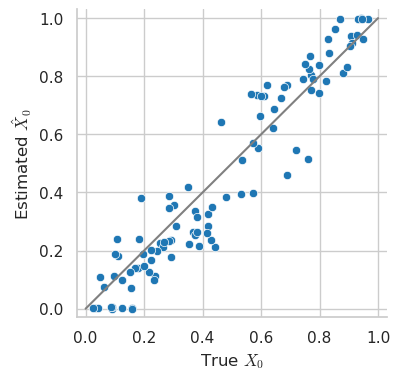

In [210]:
plt.rcParams["mathtext.fontset"] = "cm"

fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (4, 4))

#sns.scatterplot(x = high_r2[0], y = high_r2[1], ax = axes[2])
sns.scatterplot(x = median_r2[0], y = median_r2[1])#, ax = axes[1])
#sns.scatterplot(x = low_r2[0], y = low_r2[1], ax = axes[0])
axes.set_xlabel("True $X_0$")
axes.set_ylabel("Estimated $\hat{X}_0$")
sns.despine()
axes.set_xlim(-0.03,1.03)
axes.set_ylim(-0.03,1.03)
sns.lineplot((0,1), color = "grey")

fig.savefig("../paper/fig/realization_median_R2_X0_230803.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/realization_median_R2_X0_230803.png", format = "png", bbox_inches = "tight")


## Backfire

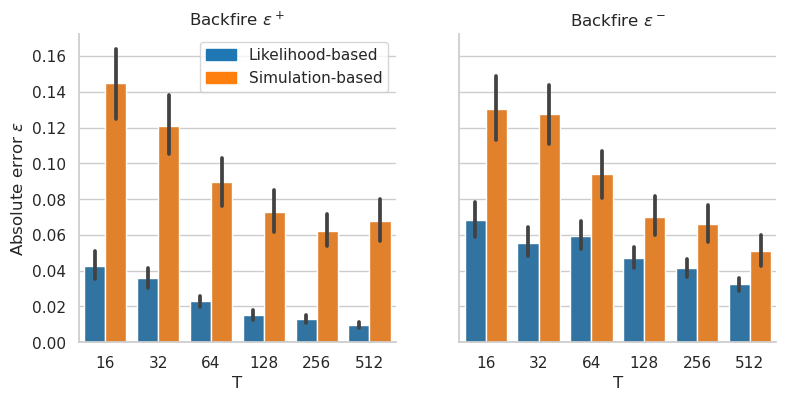

In [673]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4), sharey = True)

for ax, sign, sign_symbol in zip(axes, ["plus", "minus"], ["+", "-"]):
    sns.barplot(data = backfire_sim.set_index(["T", "edge_per_t"])[["abs_error_pgabm_"+sign, "abs_error_msm_"+sign]]\
                .rename(columns = {"abs_error_pgabm_"+sign: "pgabm", "abs_error_msm_"+sign: "msm"}).stack().reset_index()\
                .rename(columns = {"level_2": "method", 0: "abs_error"}), 
                x = "T", y = "abs_error", 
                hue = "method", 
                errorbar = ("ci", 95),
                ax = ax
               )
    ax.set_title(f"Backfire $\epsilon^{sign_symbol}$")
    #ax.set_yscale("log")
    if ax == axes[0]:
        ax.legend(handles = patches)
    else:
        ax.legend([],[], frameon = False)
    ax.set_ylabel("Absolute error $\epsilon$" if ax == axes[0] else "")

    

sns.despine()

#fig.savefig("../paper/fig/barplot_rel_error_methods_230727.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/barplot_rel_error_methods_230727.png", format = "png", bbox_inches = "tight")

In [674]:
backfire_sim.columns

Index(['ensemble_size', 'calibration_batches', 'edge_per_t', 'evidences_per_t',
       'T', 'real_epsilon_plus', 'real_epsilon_minus', 'mu_plus', 'mu_minus',
       'rho', 'epsilon_plus_msm', 'epsilon_minus_msm', 'time_msm',
       'abs_error_msm_plus', 'abs_error_msm_minus', 'rel_error_msm_plus',
       'rel_error_msm_minus', 'epsilon_plus_pgabm', 'epsilon_minus_pgabm',
       'time_pgabm', 'abs_error_pgabm_plus', 'abs_error_pgabm_minus',
       'rel_error_pgabm_plus', 'rel_error_pgabm_minus', 'X0_r2', 'X0_mae',
       'X0_mse'],
      dtype='object')

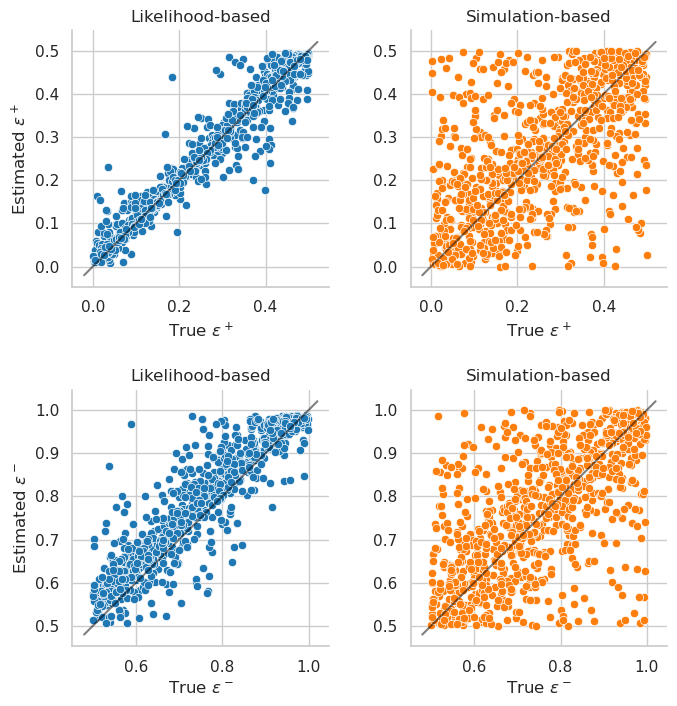

In [675]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8, 8))
plt.subplots_adjust(hspace = 0.4)

for i, sign, sign_symbol in zip(range(2), ["plus", "minus"], ["+", "-"]):
    xmin, xmax = np.array([-0.02, 0.52])  + 0.5 * i
    for j, model_name, title in zip(range(2), ["pgabm", "msm"], methods_names):
        ax = axes[i,j]

        ax.plot([xmin, xmax], [xmin, xmax], c = "k", alpha = 0.5)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.axis("square")
        ax.set_xlabel(f"True $\epsilon^{sign_symbol}$")

        ax.set_title(title)


        sns.scatterplot(data = backfire_sim, 
                        x = f"real_epsilon_{sign}", y = f"epsilon_{sign}_{model_name}", 
                        ax = ax, color = sns.color_palette()[j])
        
        ax.set_ylabel(f"Estimated $\epsilon^{sign_symbol}$" if j == 0 else "")



sns.despine()

#fig.savefig("../paper/fig/scatterplot_epsilon_evidences_230727.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/scatterplot_epsilon_evidences_230727.png", format = "png", bbox_inches = "tight")

## MSM tuning

In [280]:
msm_tuning = pd.read_csv(f"../data/tuning_calibration_batches_all_simulators_230801.csv")

In [294]:
msm_tuning.groupby(["calibration_batches", "simulator_name", "T", "edge_per_t"]).count()

N  evidences_per_t  \
calibration_batches simulator_name   T   edge_per_t                        
25                  full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partial_observed 32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
50                  full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partial_observed 32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
100                 full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partial_observed 32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
200                 full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partial_observed 32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
400                 full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partial_observed 32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
800                 full_observed    32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    noisy_observed   32  16          30               30   
                                     64  16          30               30   
                                     128 16          30               30   
                    partia

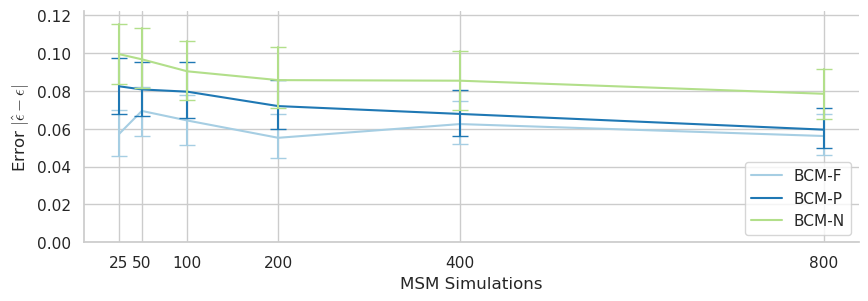

In [291]:
plt.rcParams["mathtext.fontset"] = "cm"
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 3))

sns.lineplot(data = msm_tuning, x = "calibration_batches", 
             hue = "simulator_name", y =  "distance_epsilon", 
             palette = "Paired", err_style = "bars",
             err_kws = {"capsize": 6})

axes.set_ylim(0, 0.122)

cols, _ = axes.get_legend_handles_labels()
#axes.legend(cols, model_names, loc = "lower right")
axes.legend(cols, short_model_names, loc = "lower right")
axes.set_ylabel(r"Error $\vert \hat{\epsilon} - \epsilon \vert$")
axes.set_xlabel("MSM Simulations")
    
axes.set_xticks([25, 50, 100, 200, 400, 800])

sns.despine()

fig.savefig("../paper/fig/tuning_msm_230809.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("../paper/fig/tuning_msm_230809.png", format = "png", bbox_inches = "tight")

### Printed Results

In [321]:
for model in models:
    print("")
    for quant in [0.5, 0.75, 0.9]:
        print(quant, "quantile")
        for meth in ["msm", "pgabm"]:
            print(meth, round(model[f"rel_error_{meth}"].quantile(quant), 3))
    print("")

    


0.5 quantile
msm 0.124
pgabm 0.027
0.75 quantile
msm 0.393
pgabm 0.072
0.9 quantile
msm 0.885
pgabm 0.217


0.5 quantile
msm 0.171
pgabm 0.037
0.75 quantile
msm 0.428
pgabm 0.092
0.9 quantile
msm 0.967
pgabm 0.285


0.5 quantile
msm 0.226
pgabm 0.084
0.75 quantile
msm 0.609
pgabm 0.165
0.9 quantile
msm 1.426
pgabm 0.449



In [322]:
for model in models:
    print("")
    for quant in [0.5, 0.75, 0.9]:
        print(quant, "quantile")
        for meth in ["msm", "pgabm"]:
            print(meth, round(model[f"abs_error_{meth}"].quantile(quant), 3))
    print("")

    


0.5 quantile
msm 0.027
pgabm 0.006
0.75 quantile
msm 0.062
pgabm 0.014
0.9 quantile
msm 0.118
pgabm 0.025


0.5 quantile
msm 0.036
pgabm 0.008
0.75 quantile
msm 0.072
pgabm 0.018
0.9 quantile
msm 0.129
pgabm 0.03


0.5 quantile
msm 0.047
pgabm 0.018
0.75 quantile
msm 0.106
pgabm 0.034
0.9 quantile
msm 0.188
pgabm 0.058



In [320]:
for model, model_name in zip(models + [pd.concat(models)], model_names + ["Aggregate"]):
    print("Median delta epsilon ratio", model_name, 
          round(model.assign(delta_ratio_epsilon = lambda x: x["abs_error_msm"] / x["abs_error_pgabm"]).median()["delta_ratio_epsilon"], 3))

Median delta epsilon ratio Fully observed 3.963
Median delta epsilon ratio Partially observed  4.412
Median delta epsilon ratio Noisy observations 2.6
Median delta epsilon ratio Aggregate 3.121


In [323]:
for err_var, method_name in zip(["abs_error_pgabm", "abs_error_msm"], methods_names):
    print(method_name, pd.concat(models)[err_var].median())

Likelihood-based 0.0129475518724065
Simulation-based 0.039915971768539504


In [324]:
for model, model_name in zip(models + [pd.concat(models)], model_names + ["Aggregate"]):
    print("Median time ratio", model_name, 
          round(model.assign(time_ratio = lambda x: x["time_msm"] / x["time_pgabm"]).median()["time_ratio"], 3))

Median time ratio Fully observed 207.011
Median time ratio Partially observed  11.856
Median time ratio Noisy observations 2.171
Median time ratio Aggregate 3.927


In [325]:
for time_var, method_name in zip(["time_pgabm", "time_msm"], methods_names):
    print(method_name, pd.concat(models)[time_var].median())

Likelihood-based 1.7237164974212646
Simulation-based 7.5309590101242065


In [326]:
print("Median R2 high T", round(evidences_sim.query("T>64").median()["X0_r2"], 4))

Median R2 high T 0.8979


In [327]:
evidences_sim.median()[["X0_r2", "X0_mae", "X0_mse"]]

X0_r2     0.811211
X0_mae    0.097992
X0_mse    0.018721
dtype: float64

### Tables

In [328]:
print(simple_bc_sim.groupby(["T", "edge_per_t"]).median().apply(lambda x: round(x, 3))\
      [["abs_error_pgabm","abs_error_msm", "time_pgabm",  "time_msm"]]\
      .rename(index = {"edge_per_t": "m"}, 
              columns = {"time_pgabm": "t_{ML}", "time_msm": "t_{MSM}", "abs_error_pgabm": "\delta_{ML}", "abs_error_msm": "\delta_{MSM}"})\
      .to_latex())


\begin{tabular}{llrrrr}
\toprule
    &    &  \textbackslash delta\_\{ML\} &  \textbackslash delta\_\{MSM\} &  t\_\{ML\} &  t\_\{MSM\} \\
T & edge\_per\_t &              &               &         &          \\
\midrule
16  & 1  &        0.036 &         0.074 &   0.025 &    1.438 \\
    & 4  &        0.019 &         0.079 &   0.025 &    1.601 \\
    & 16 &        0.012 &         0.084 &   0.024 &    1.601 \\
    & 64 &        0.005 &         0.064 &   0.025 &    1.610 \\
32  & 1  &        0.021 &         0.043 &   0.023 &    2.131 \\
    & 4  &        0.014 &         0.062 &   0.026 &    2.477 \\
    & 16 &        0.007 &         0.064 &   0.025 &    2.478 \\
    & 64 &        0.004 &         0.032 &   0.026 &    2.493 \\
64  & 1  &        0.018 &         0.027 &   0.027 &    3.511 \\
    & 4  &        0.010 &         0.058 &   0.026 &    4.217 \\
    & 16 &        0.006 &         0.045 &   0.026 &    4.227 \\
    & 64 &        0.003 &         0.017 &   0.029 &    4.253 \\
128 & 1  &    

/tmp/ipykernel_969863/3418898831.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(simple_bc_sim.groupby(["T", "edge_per_t"]).median().apply(lambda x: round(x, 3))\


In [329]:
print(pos_obs_sim.groupby(["T", "edge_per_t"]).median().apply(lambda x: round(x, 3))\
      [["abs_error_pgabm","abs_error_msm", "time_pgabm",  "time_msm"]]\
      .rename(index = {"edge_per_t": "m"}, 
              columns = {"time_pgabm": "t_{ML}", "time_msm": "t_{MSM}", "abs_error_pgabm": "\delta_{ML}", "abs_error_msm": "\delta_{MSM}"})\
      .to_latex())


\begin{tabular}{llrrrr}
\toprule
    &    &  \textbackslash delta\_\{ML\} &  \textbackslash delta\_\{MSM\} &  t\_\{ML\} &  t\_\{MSM\} \\
T & edge\_per\_t &              &               &         &          \\
\midrule
16  & 1  &        0.035 &         0.076 &   0.185 &    2.088 \\
    & 4  &        0.020 &         0.080 &   0.177 &    2.093 \\
    & 16 &        0.011 &         0.096 &   0.172 &    2.089 \\
    & 64 &        0.007 &         0.090 &   0.186 &    2.101 \\
32  & 1  &        0.029 &         0.041 &   0.297 &    3.443 \\
    & 4  &        0.015 &         0.053 &   0.302 &    3.465 \\
    & 16 &        0.010 &         0.073 &   0.320 &    3.455 \\
    & 64 &        0.006 &         0.051 &   0.305 &    3.478 \\
64  & 1  &        0.021 &         0.030 &   0.560 &    6.146 \\
    & 4  &        0.011 &         0.042 &   0.534 &    6.191 \\
    & 16 &        0.007 &         0.063 &   0.532 &    6.171 \\
    & 64 &        0.003 &         0.039 &   0.555 &    6.216 \\
128 & 1  &    

/tmp/ipykernel_969863/1583964789.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pos_obs_sim.groupby(["T", "edge_per_t"]).median().apply(lambda x: round(x, 3))\


In [330]:
print(evidences_sim.groupby(["T", "edge_per_t", "evidences_per_t"]).median().apply(lambda x: round(x, 3))\
      [["abs_error_pgabm","abs_error_msm", "time_pgabm",  "time_msm"]]\
      .rename(index = {"edge_per_t": "m"}, 
              columns = {"time_pgabm": "t_{ML}", "time_msm": "t_{MSM}", "abs_error_pgabm": "\delta_{ML}", "abs_error_msm": "\delta_{MSM}"})\
      .to_latex())


\begin{tabular}{lllrrrr}
\toprule
    &    &    &  \textbackslash delta\_\{ML\} &  \textbackslash delta\_\{MSM\} &  t\_\{ML\} &  t\_\{MSM\} \\
T & edge\_per\_t & evidences\_per\_t &              &               &         &          \\
\midrule
16  & 1  & 4  &        0.060 &         0.074 &   1.055 &    2.768 \\
    &    & 8  &        0.059 &         0.079 &   1.111 &    2.758 \\
    &    & 16 &        0.057 &         0.075 &   0.870 &    2.750 \\
    & 4  & 4  &        0.045 &         0.106 &   0.838 &    2.899 \\
    &    & 8  &        0.035 &         0.131 &   0.903 &    2.900 \\
    &    & 16 &        0.037 &         0.115 &   0.796 &    2.901 \\
    & 16 & 4  &        0.026 &         0.150 &   0.754 &    2.902 \\
    &    & 8  &        0.026 &         0.136 &   0.734 &    2.903 \\
    &    & 16 &        0.022 &         0.140 &   0.730 &    2.903 \\
    & 64 & 4  &        0.014 &         0.103 &   0.724 &    2.910 \\
    &    & 8  &        0.017 &         0.128 &   0.662 &    2.926 

/tmp/ipykernel_969863/342178841.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(evidences_sim.groupby(["T", "edge_per_t", "evidences_per_t"]).median().apply(lambda x: round(x, 3))\
